In [1]:
import torch
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

sys.path.append('../embedding')
from gym_dataset import AbstractActionsData

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
encoder = torch.load('results/dmc_hopper_hop/dmc_first_try/model.pt')

data_tuned = AbstractActionsData('dmc_hopper_hop', 4, encoder)
data_raw = AbstractActionsData('dmc_hopper_hop', 4, encoder)

data_tuned.load_stats('datasets')
data_raw.load_stats('datasets')

data_tuned.load_from_directory('datasets/dreamer_finetuned/episodes')
data_raw.load_from_directory('datasets/dreamer_raw/episodes')

In [4]:
mu, std = data_tuned.transform_episode(0)
episode_len = mu.size(0)
mu_size = mu.size(1)
std_size = std.size(1)

mu_tuned = np.zeros([len(data_tuned), episode_len, mu_size])
std_tuned = np.zeros([len(data_tuned), episode_len, std_size])
mu_raw = np.zeros([len(data_raw), episode_len, mu_size])
std_raw = np.zeros([len(data_raw), episode_len, std_size])
for i in range(len(data_tuned)):
    mu_tuned[i], std_tuned[i] = data_tuned.transform_episode(i)
for i in range(len(data_raw)):
    mu_raw[i], std_raw[i] = data_raw.transform_episode(i)

In [5]:
mu_mean_diff = mu_tuned.mean(axis=0) - mu_raw.mean(axis=0)
std_mean_diff = std_tuned.mean(axis=0) - std_raw.mean(axis=0)
mu_std_diff = mu_tuned.std(axis=0) - mu_raw.std(axis=0)
std_std_diff = std_tuned.std(axis=0) - std_raw.std(axis=0)

Text(0.5, 1.0, 'Mean Std, dreamer_raw')

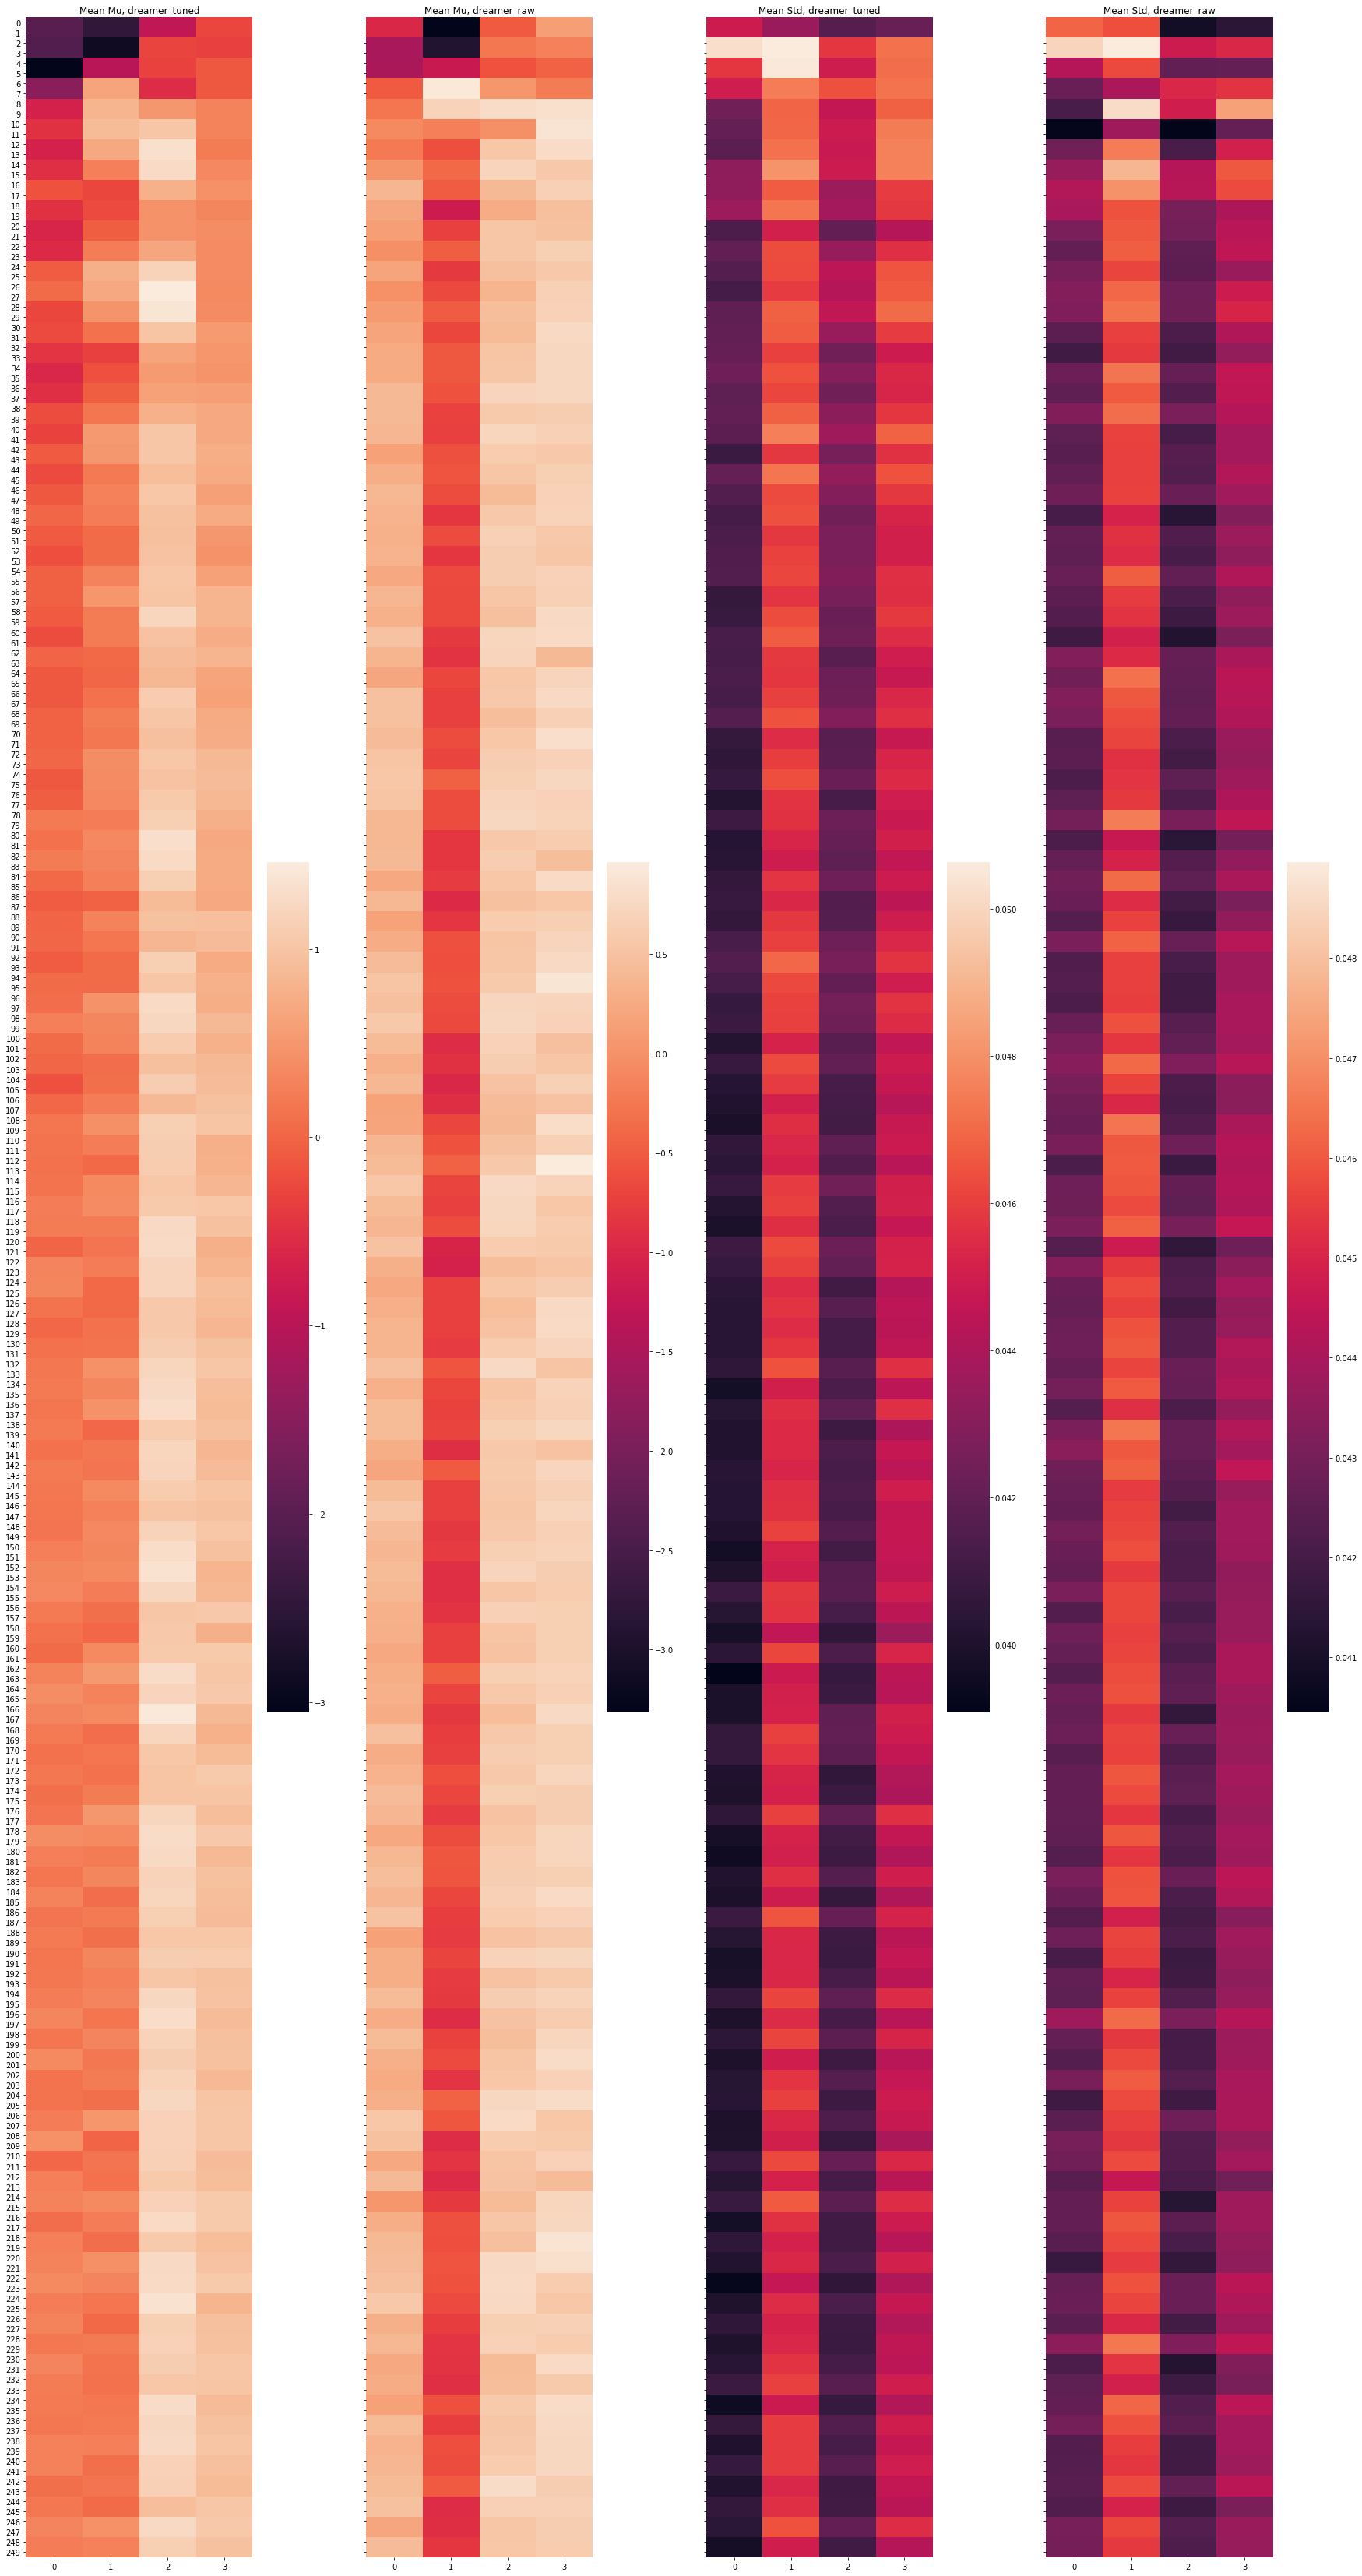

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 60), sharey=True)

x = sns.heatmap(mu_tuned.mean(axis=0), ax=ax1)
ax1.set_title('Mean Mu, dreamer_tuned')
y = sns.heatmap(mu_raw.mean(axis=0), ax=ax2)
ax2.set_title('Mean Mu, dreamer_raw')

z = sns.heatmap(np.exp(std_tuned/2).mean(axis=0), ax=ax3)
ax3.set_title('Mean Std, dreamer_tuned')
w = sns.heatmap(np.exp(std_raw/2).mean(axis=0), ax=ax4)
ax4.set_title('Mean Std, dreamer_raw')

Text(0.5, 1.0, 'Std of Std, dreamer_raw')

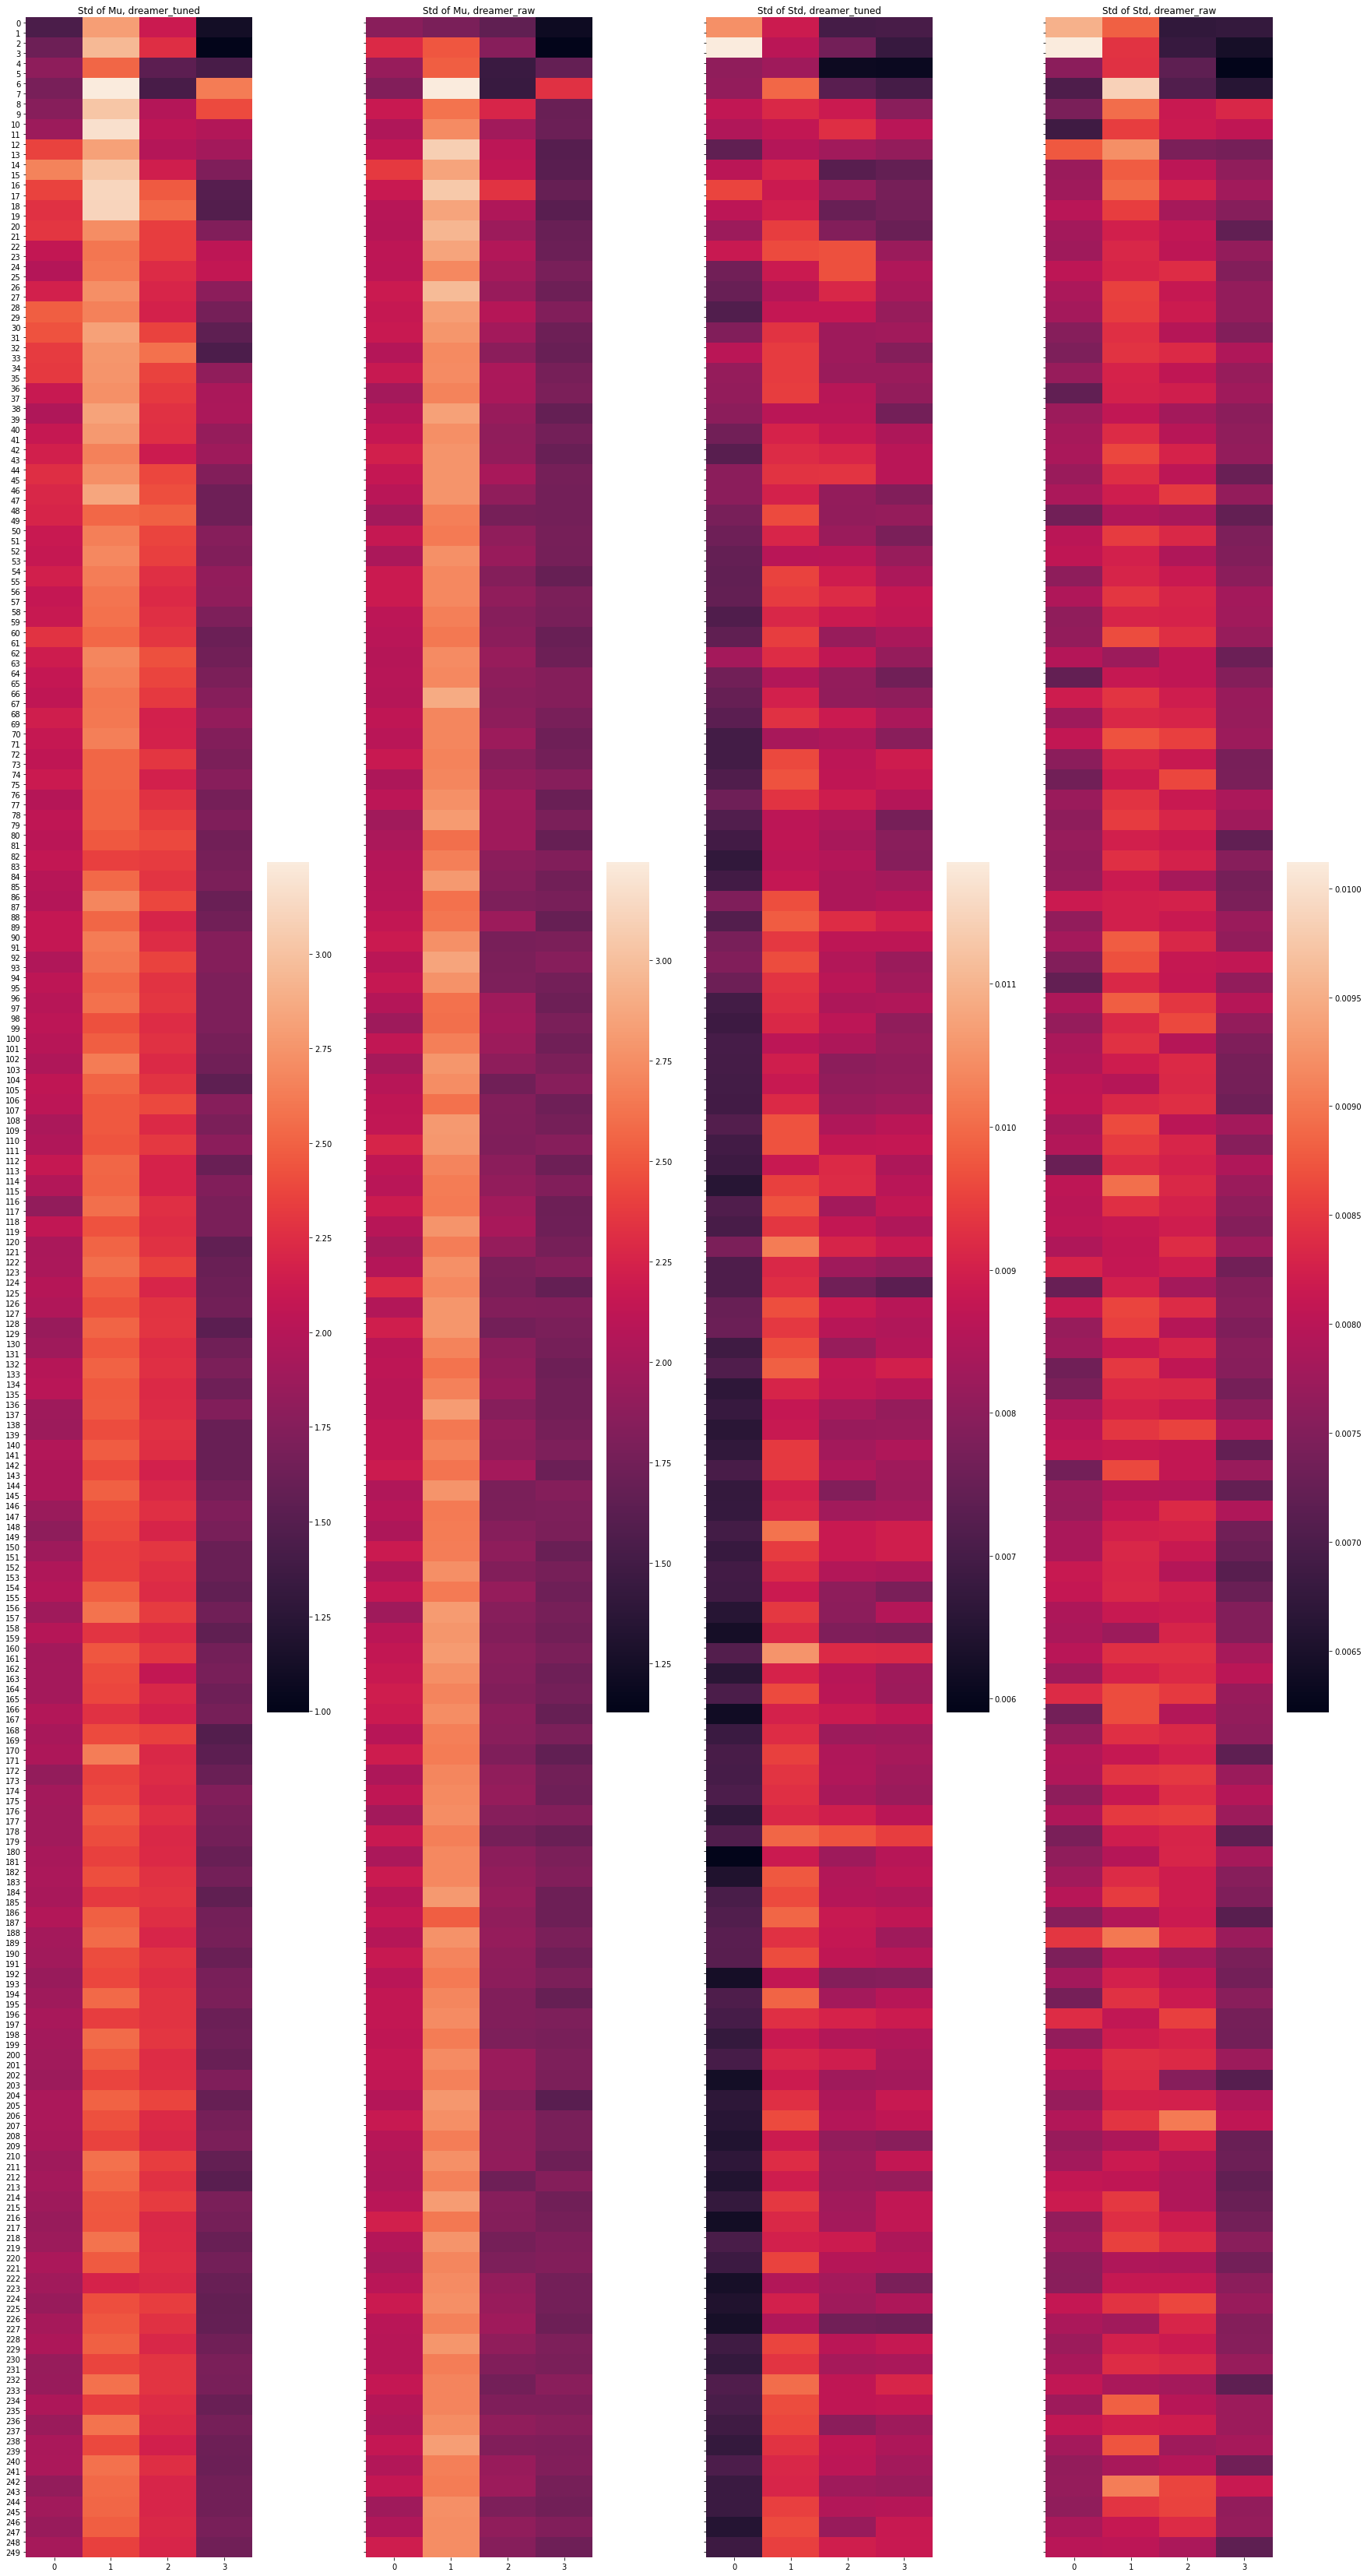

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 60), sharey=True)

x = sns.heatmap(mu_tuned.std(axis=0), ax=ax1)
ax1.set_title('Std of Mu, dreamer_tuned')
y = sns.heatmap(mu_raw.std(axis=0), ax=ax2)
ax2.set_title('Std of Mu, dreamer_raw')

z = sns.heatmap(np.exp(std_tuned/2).std(axis=0), ax=ax3)
ax3.set_title('Std of Std, dreamer_tuned')
w = sns.heatmap(np.exp(std_raw/2).std(axis=0), ax=ax4)
ax4.set_title('Std of Std, dreamer_raw')

Text(0.5, 1.0, 'Difference between Std of Std')

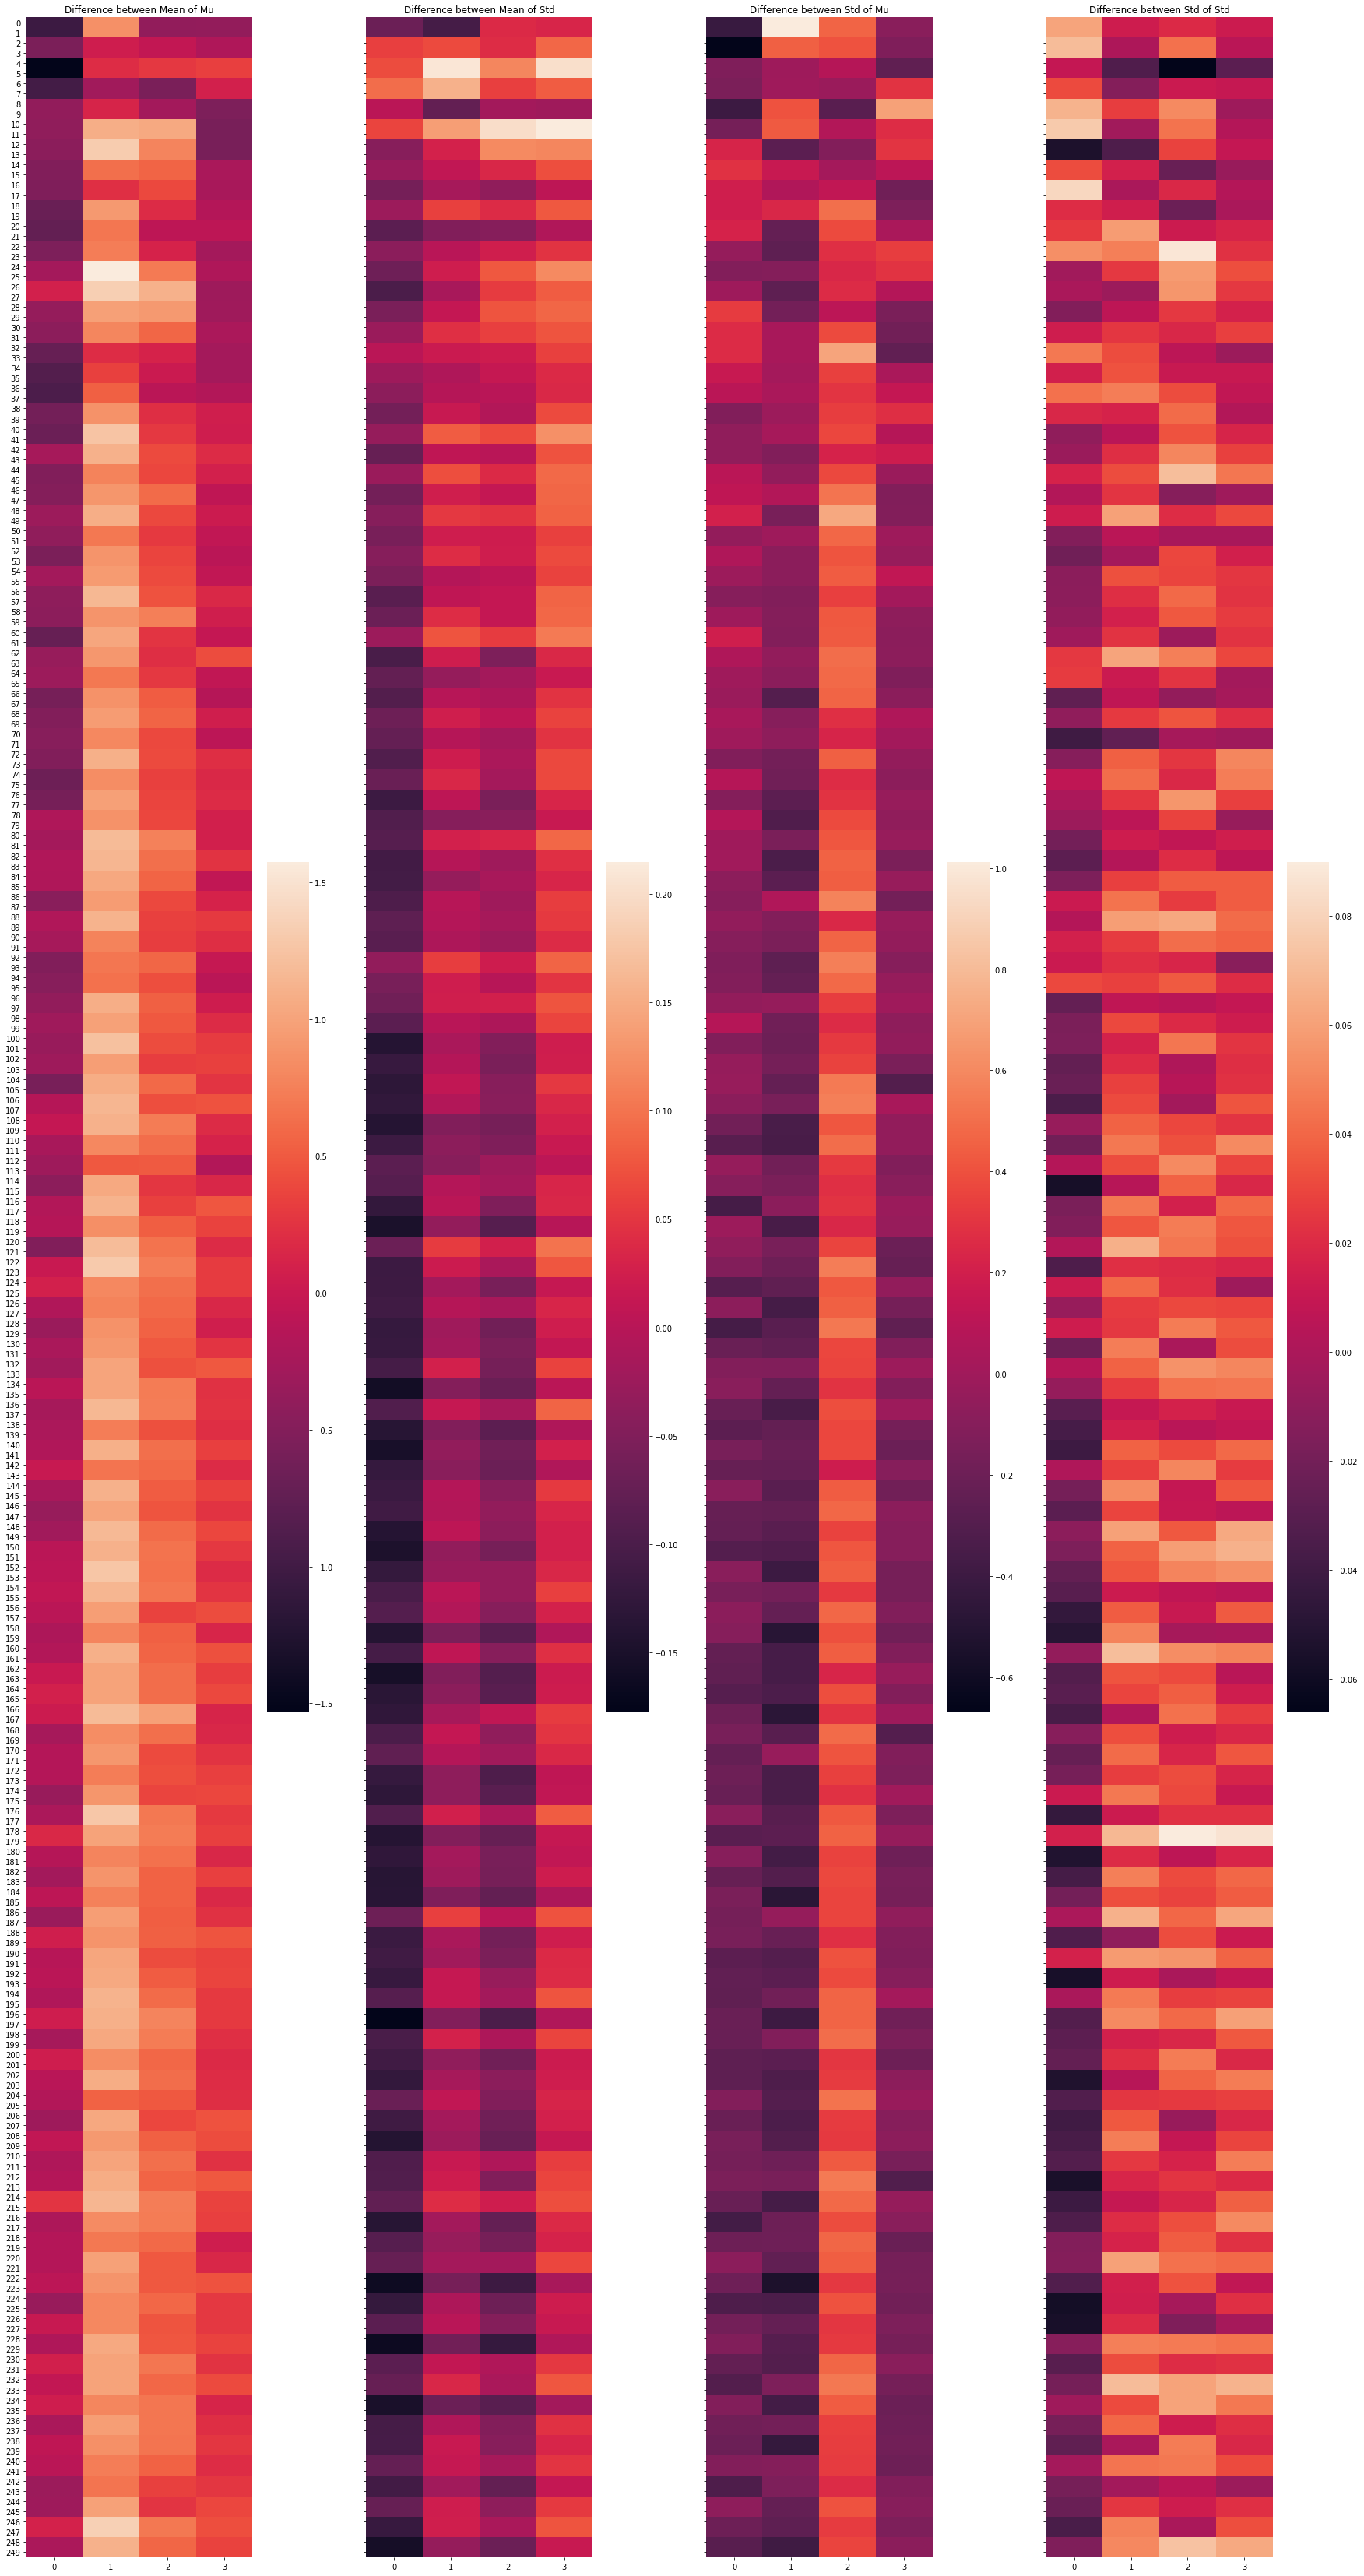

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 60), sharey=True)

x = sns.heatmap(mu_mean_diff, ax=ax1)
ax1.set_title('Difference between Mean of Mu')
y = sns.heatmap(std_mean_diff, ax=ax2)
ax2.set_title('Difference between Mean of Std')

z = sns.heatmap(mu_std_diff, ax=ax3)
ax3.set_title('Difference between Std of Mu')
w = sns.heatmap(std_std_diff, ax=ax4)
ax4.set_title('Difference between Std of Std')

In [9]:
z_mean, z_std, z_white_max = torch.load('datasets/z_stats.pt')

In [10]:
decoder = torch.load('results/dmc_hopper_hop/dmc_first_try/decoder.pt')

In [12]:
decoded_action = decoder(torch.from_numpy(mu_tuned[0]).float())
episode_len = decoded_action.size(0)
traj_len = decoded_action.size(1)
action_size = decoded_action.size(1)

dec_act_tuned = np.zeros([len(data_tuned), episode_len * traj_len, action_size])
act_tuned = np.zeros([len(data_tuned), episode_len * traj_len, action_size])
dec_act_raw = np.zeros([len(data_raw), episode_len * traj_len, action_size])
act_raw = np.zeros([len(data_raw), episode_len * traj_len, action_size])
with torch.no_grad():
    for i in range(len(mu_tuned)):
        z = torch.from_numpy(mu_tuned[i]).float()
        z_whitened = (z - z_mean) / z_std
        dec_act_tuned[i] = decoder(z_whitened).reshape([episode_len * traj_len, action_size])
        act_tuned[i] = np.repeat(data_tuned[i][1][1:], 2, axis=0)
    for i in range(len(mu_raw)):
        z = torch.from_numpy(mu_raw[i]).float()
        z_whitened = (z - z_mean) / z_std
        dec_act_raw[i] = decoder(z_whitened).reshape([episode_len * traj_len, action_size])
        act_raw[i] = np.repeat(data_raw[i][1][1:], 2, axis=0)

In [13]:
decoder_diff_mean_tuned = dec_act_tuned.mean(0) - act_tuned.mean(0)
decoder_diff_mean_raw = dec_act_raw.mean(0) - act_raw.mean(0)

Text(0.5, 1.0, 'Decoder/orig mean actions abs diff, dreamer_raw')

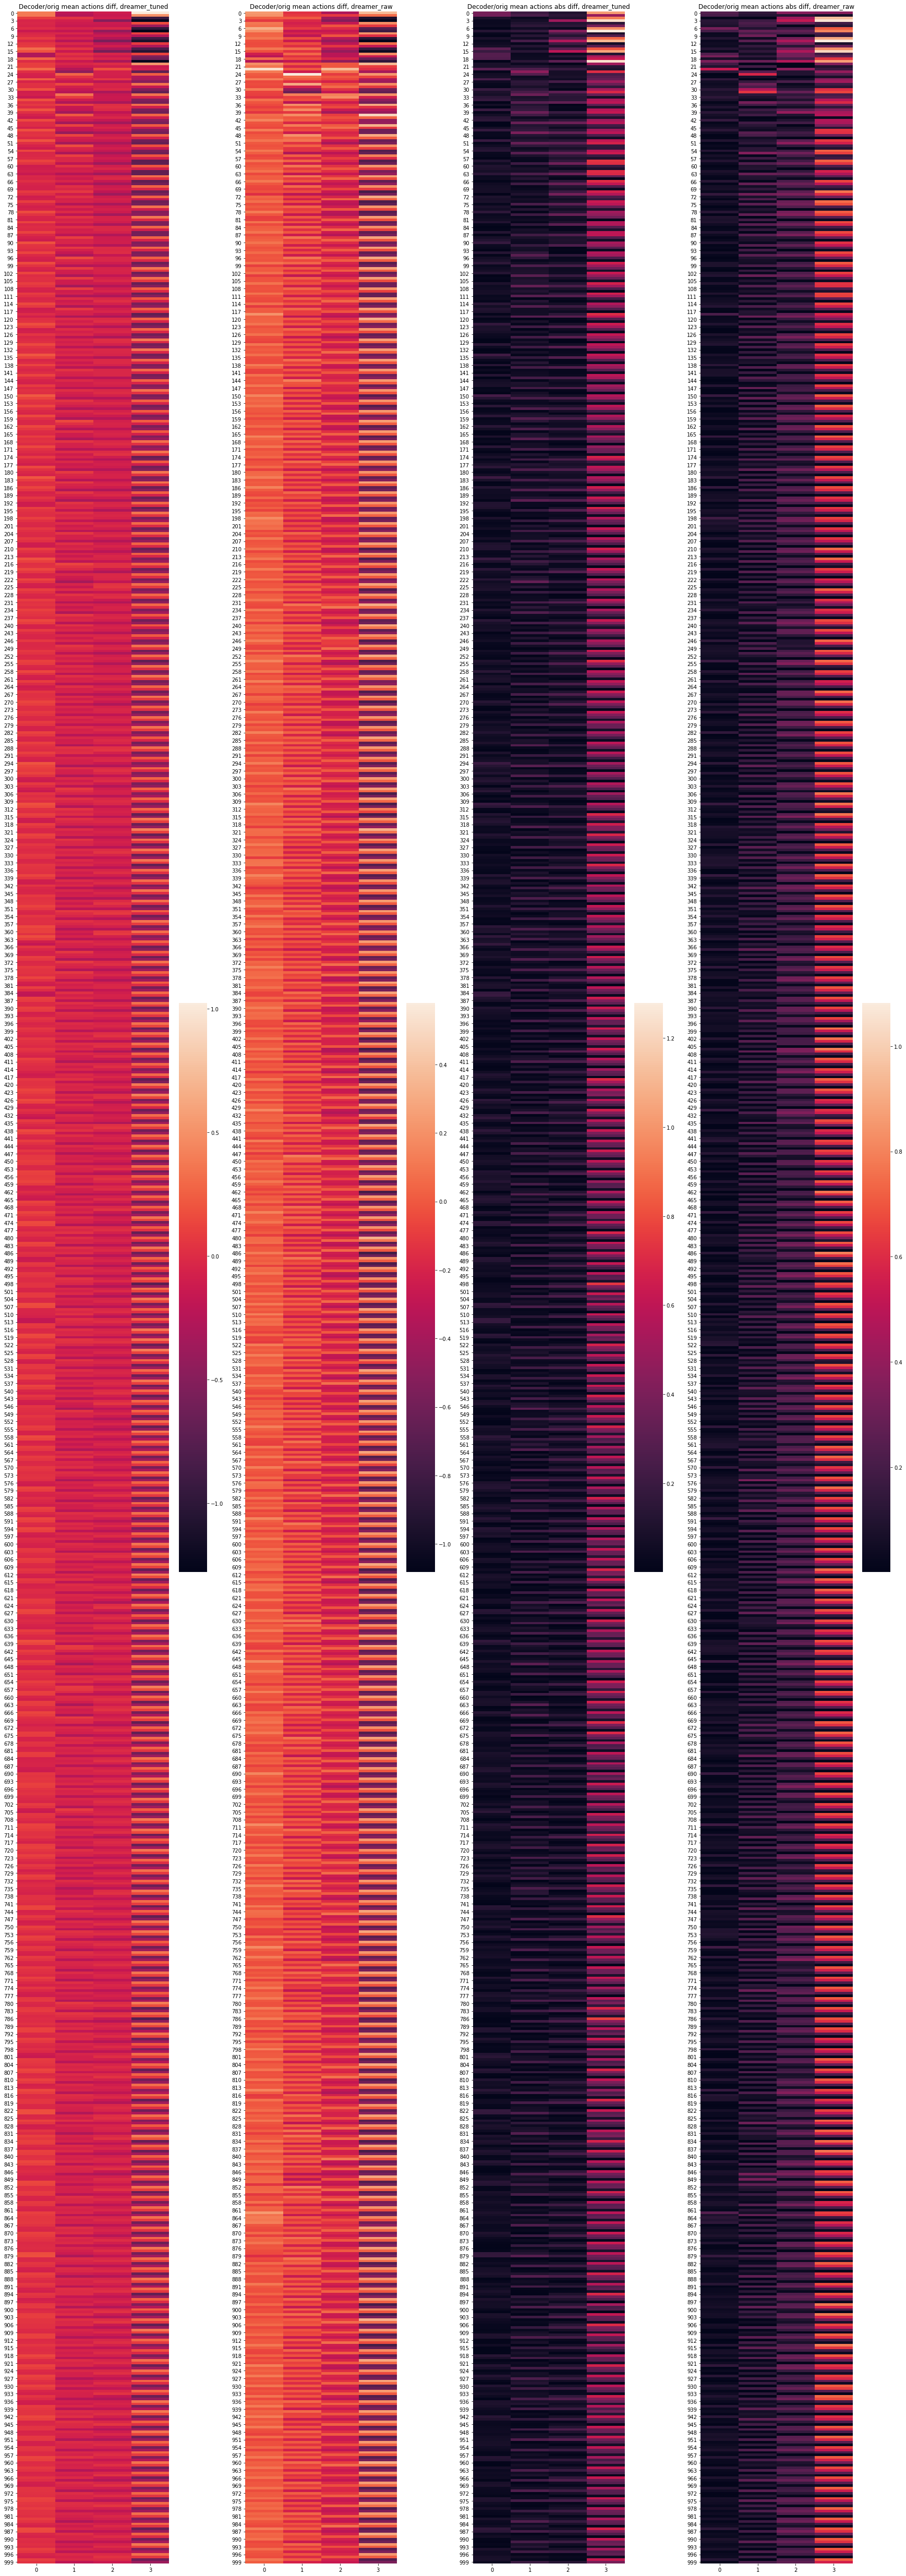

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 90))

x = sns.heatmap(decoder_diff_mean_tuned, ax=ax1)
ax1.set_title('Decoder/orig mean actions diff, dreamer_tuned')

y = sns.heatmap(decoder_diff_mean_raw, ax=ax2)
ax2.set_title('Decoder/orig mean actions diff, dreamer_raw')

z = sns.heatmap(np.abs(decoder_diff_mean_tuned), ax=ax3)
ax3.set_title('Decoder/orig mean actions abs diff, dreamer_tuned')

w = sns.heatmap(np.abs(decoder_diff_mean_raw), ax=ax4)
ax4.set_title('Decoder/orig mean actions abs diff, dreamer_raw')

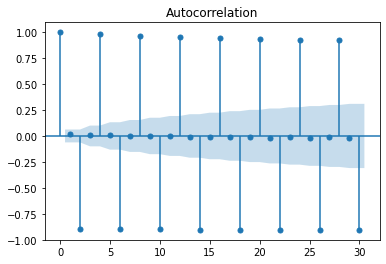

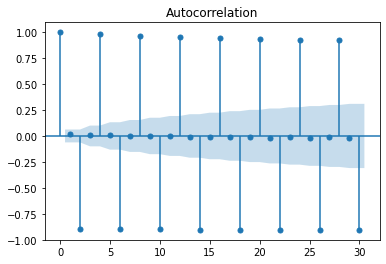

In [28]:
plot_acf(dec_act_tuned.mean(axis=0)[:, 3])

In [29]:
dec_act_tuned.mean(axis=0)[:, 3]

array([ 9.35206242e-01,  4.01542594e-01, -1.22641611e-01, -4.20925762e-01,
        9.35206242e-01,  4.01542594e-01, -1.22641611e-01, -4.20925762e-01,
        9.39334509e-01,  5.72286853e-01, -2.09068040e-02, -2.45967821e-01,
        9.39334509e-01,  5.72286853e-01, -2.09068040e-02, -2.45967821e-01,
        8.77347587e-01,  2.28912137e-01,  1.51786358e-01, -4.57612270e-01,
        8.77347587e-01,  2.28912137e-01,  1.51786358e-01, -4.57612270e-01,
        2.28713836e-01, -2.84115178e-01, -5.18757512e-01, -6.85193912e-01,
        2.28713836e-01, -2.84115178e-01, -5.18757512e-01, -6.85193912e-01,
        3.89657086e-01, -2.94438670e-02, -4.80525515e-01, -5.22968161e-01,
        3.89657086e-01, -2.94438670e-02, -4.80525515e-01, -5.22968161e-01,
        4.24988018e-01,  4.50963242e-02, -3.42568392e-01, -4.08491671e-01,
        4.24988018e-01,  4.50963242e-02, -3.42568392e-01, -4.08491671e-01,
        5.64226522e-01,  2.27888991e-01, -2.66069514e-01, -3.23893618e-01,
        5.64226522e-01,  

In [222]:
np.repeat(data_tuned[0][1][1:], 2, axis=0)

tensor([[-0.8157,  0.9369,  0.8853,  0.9901],
        [-0.8157,  0.9369,  0.8853,  0.9901],
        [ 0.9999, -0.9314,  0.9824,  0.9999],
        ...,
        [-0.9994, -0.9995, -0.9903, -0.9992],
        [-0.9998,  0.9987,  0.9998,  0.9998],
        [-0.9998,  0.9987,  0.9998,  0.9998]])